TODO: 
- add parallax as a data coordinate of the model
- Gaia selection function: 
    - Need to explicitly model the probability of a given apparent (absolute?) magnitude at different parts of the stream
    - The poisson process effective volume integral here has to use the Gaia selection function
- Iterate: Use this to improve the distance trend and CMD selection
- Make spur model more general (2D grid of gaussians at same proper motions??) to capture all off-track features

In [1]:
import pathlib
import pickle

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gala.coordinates as gc

from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jaxopt

import numpyro
from numpyro_ext.optim import optimize
numpyro.enable_x64()
from numpyro import infer

from pyia import GaiaData

import scipy.optimize as sco
import scipy.interpolate as sci
import scipy.stats as scs
import scipy.ndimage as scn
import scipy.special as scsp

from stream_membership import SplineDensityMixtureModel
from stream_membership.helpers import two_truncated_normal_mixture, two_normal_mixture
from stream_membership.plot import plot_data_projections
from gd1_helpers.membership import GD1BackgroundModel, GD1StreamModel
from gd1_helpers.membership.initialize import BackgroundInitializer, StreamInitializer

In [2]:
data_path = pathlib.Path('../data').resolve().absolute()
cache_path = pathlib.Path('../cache').resolve().absolute()

See: `3-Initial-stream-track.ipynb`

In [3]:
g = GaiaData(data_path / 'gd1-GaiaDR3-PS1DR2-joined.fits')

phi1_lim = GD1StreamModel.coord_bounds['phi1']
phi2_mask = (
    (g.gd1_phi1 > phi1_lim[0]) & 
    (g.gd1_phi1 < phi1_lim[1]) & 
    (g.gd1_phi2 > GD1BackgroundModel.coord_bounds['phi2'][0]) & 
    (g.gd1_phi2 < GD1BackgroundModel.coord_bounds['phi2'][1])
)
g = g[phi2_mask]

len(g)

6520791

In [4]:
masks = at.Table.read(cache_path / 'init-masks.fits')[phi2_mask]
masks['G19.5'] = g.phot_g_mean_mag < 19.5*u.mag

In [5]:
with open(data_path / 'galcen_frame.pkl', 'rb') as f:
    galcen_frame = pickle.load(f)

In [6]:
c = g.get_skycoord(
    distance=coord.Distance(distmod=g.rough_distmod),
    radial_velocity=0*u.km/u.s
)
gd1_frame = gc.GD1Koposov10()
c_gd1 = c.transform_to(gd1_frame)
c_gd1_refl = gc.reflex_correct(c_gd1, galcen_frame)

Note: We use a past distance trend (de Boer paper) to compute initial solar reflex-corrected proper motions, but do a conservative cut using these.

In [7]:
pm_cov = g.get_cov()[:, 3:5, 3:5]
pm_cov_gd1 = gc.transform_pm_cov(c, pm_cov, gd1_frame)

pm1 = c_gd1_refl.pm_phi1_cosphi2.value
pm2 = c_gd1_refl.pm_phi2.value
pm1_err = np.sqrt(pm_cov_gd1[:, 0, 0])
pm2_err = np.sqrt(pm_cov_gd1[:, 1, 1])
del pm_cov, pm_cov_gd1

masks['pm1_lim'] = (
    (pm1 > GD1StreamModel.coord_bounds['pm1'][0]) &
    (pm1 < GD1StreamModel.coord_bounds['pm1'][1])
)

In [8]:
all_data = {
    'phi1': c_gd1.phi1.degree,
    'phi2': c_gd1.phi2.degree,
    'pm1': pm1,
    'pm1_err': pm1_err,
    'pm2': pm2,
    'pm2_err': pm2_err,
}

for k, v in all_data.items():
    all_data[k] = np.array(v, copy=True, dtype=np.float64)
    assert np.all(np.isfinite(all_data[k]))

In [9]:
run_mask = masks['cmd_ms'] & masks['pm1_lim']
run_data = {k: v[run_mask] for k, v in all_data.items()}
# at.Table(run_data).write(cache_path / 'run_data.fits', overwrite=True);

# Background initialization

In [10]:
bkg_mask = run_mask & ~masks['sky_track']
bkg_g = g[bkg_mask]
bkg_data = {k: v[bkg_mask] for k, v in all_data.items()}

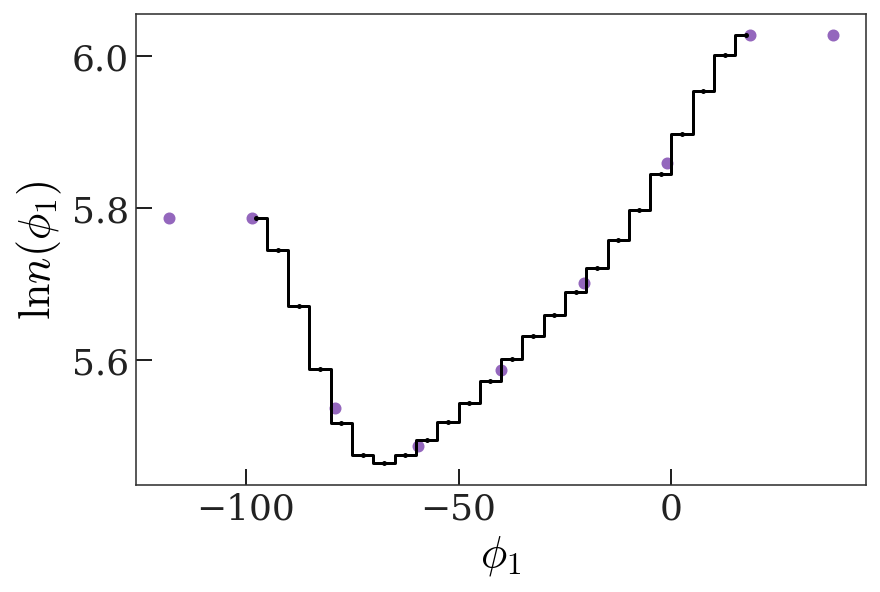

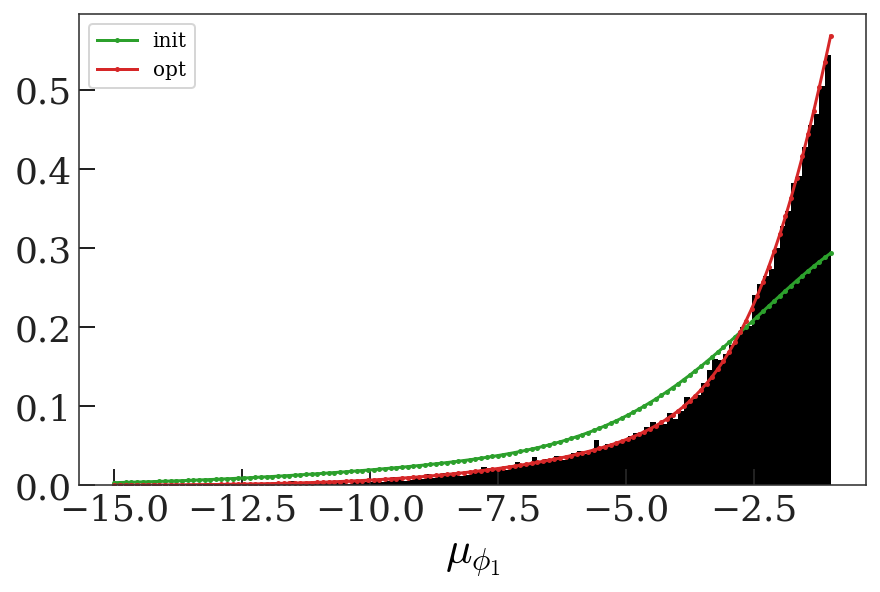

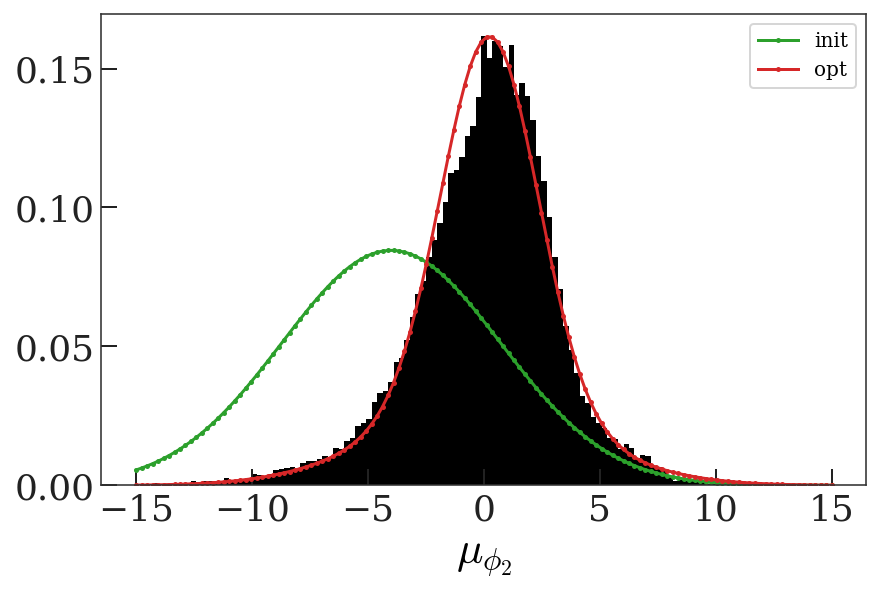

In [11]:
bkg_initter = BackgroundInitializer(bkg_data, plot=True)
bkg_init_p = bkg_initter.init()
bkg_init_p = GD1BackgroundModel.clip_params(bkg_init_p)

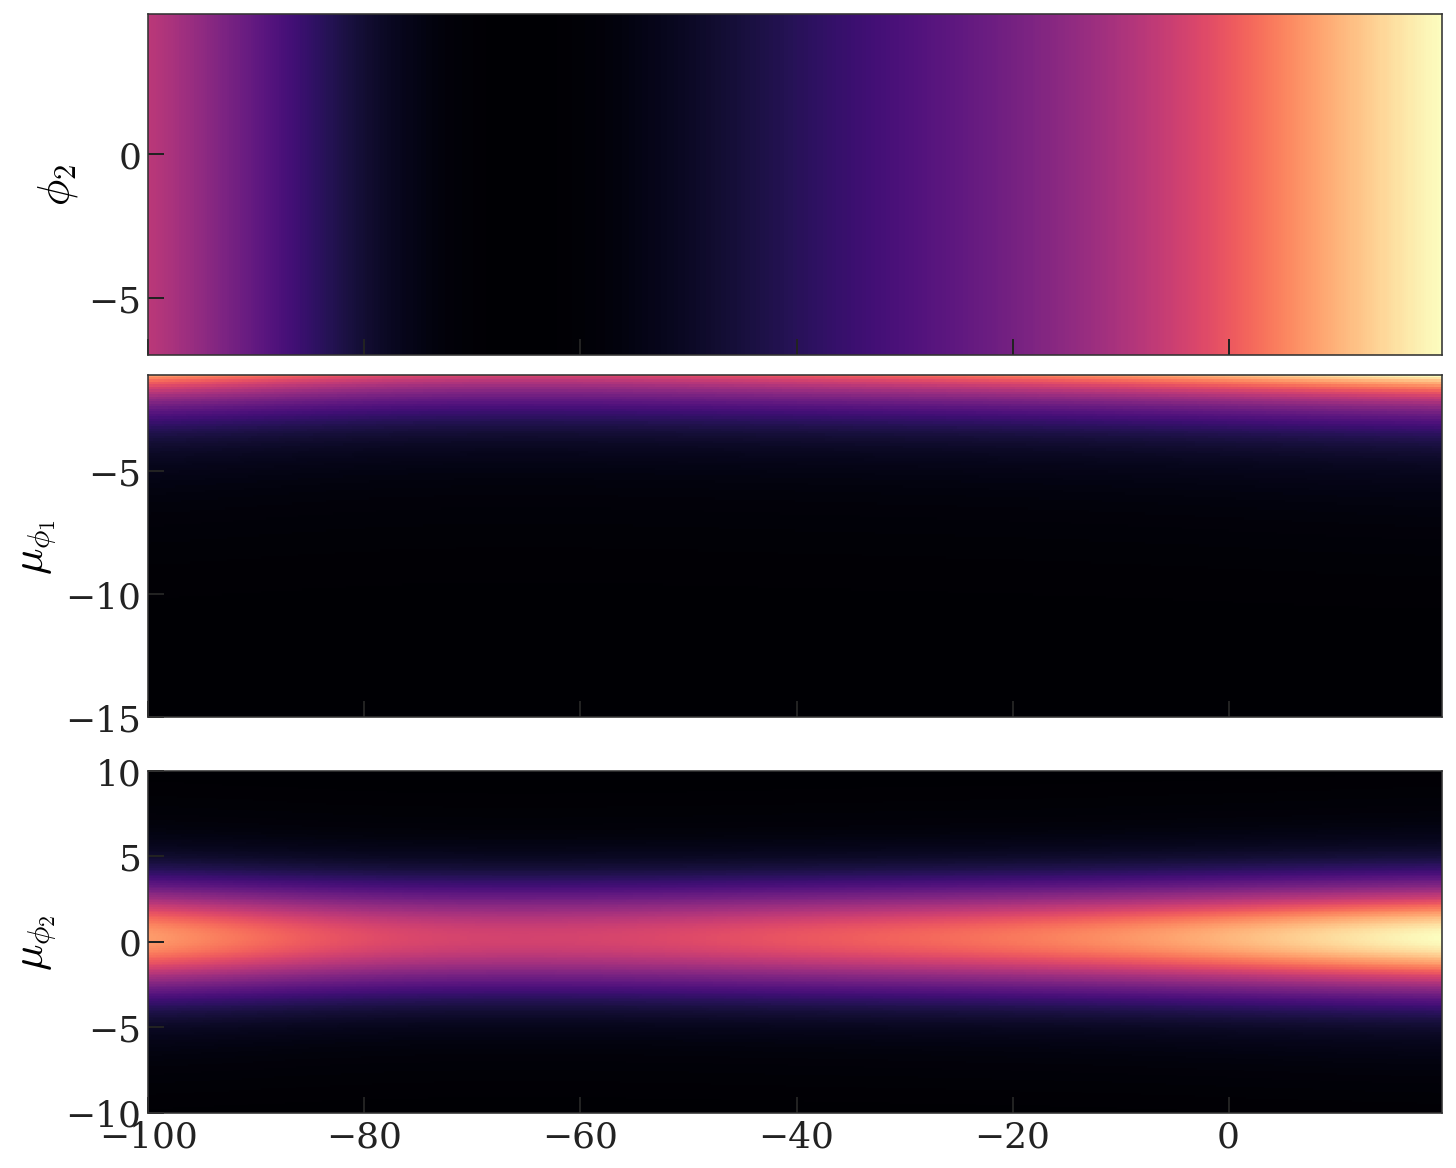

In [12]:
background_init = GD1BackgroundModel(bkg_init_p)
_ = background_init.plot_model_projections()

In [13]:
background_init.ln_likelihood(bkg_data)

DeviceArray(-70680.90208143, dtype=float64)

In [14]:
# bkg_opt_pars, bkg_info = GD1BackgroundModel.optimize(
#     data=bkg_data, init_params=bkg_init_p, use_bounds=False
# )
# background_opt = GD1BackgroundModel(bkg_opt_pars)
# bkg_info

In [15]:
optimizer = jaxopt.ScipyBoundedMinimize(
    'l-bfgs-b',
    fun=GD1BackgroundModel.objective,
    options=dict(maxls=10000),
    maxiter=100_000, 
)
opt_res = optimizer.run(
    init_params=bkg_init_p, 
    data=bkg_data,
    bounds=GD1BackgroundModel._get_jaxopt_bounds()
)
bkg_opt_pars = opt_res.params
opt_res.state

ScipyMinimizeInfo(fun_val=DeviceArray(1.87970834, dtype=float64, weak_type=True), success=True, status=0, iter_num=1679)

In [16]:
background_opt = GD1BackgroundModel(bkg_opt_pars)

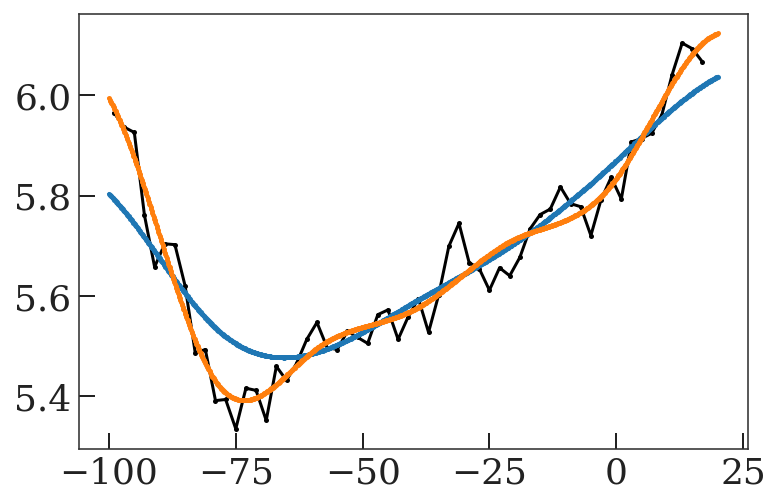

In [17]:
grid = np.linspace(*phi1_lim, 1024)
phi1_bins = np.arange(*GD1BackgroundModel.coord_bounds['phi1'], 2.)
phi1_binc = 0.5 * (phi1_bins[:-1] + phi1_bins[1:])

H, xe = np.histogram(bkg_data['phi1'], bins=phi1_bins)
plt.figure(figsize=(6, 4))
plt.plot(phi1_binc, np.log(H / np.diff(phi1_bins)[0]))

spl = sci.InterpolatedUnivariateSpline(
    GD1BackgroundModel.knots['ln_n0'],
    bkg_init_p['ln_n0'],
    k=GD1BackgroundModel.spline_ks['ln_n0']
)
plt.plot(grid, spl(grid))

spl = sci.InterpolatedUnivariateSpline(
    GD1BackgroundModel.knots['ln_n0'],
    bkg_opt_pars['ln_n0'],
    k=GD1BackgroundModel.spline_ks['ln_n0']
)
plt.plot(grid, spl(grid))

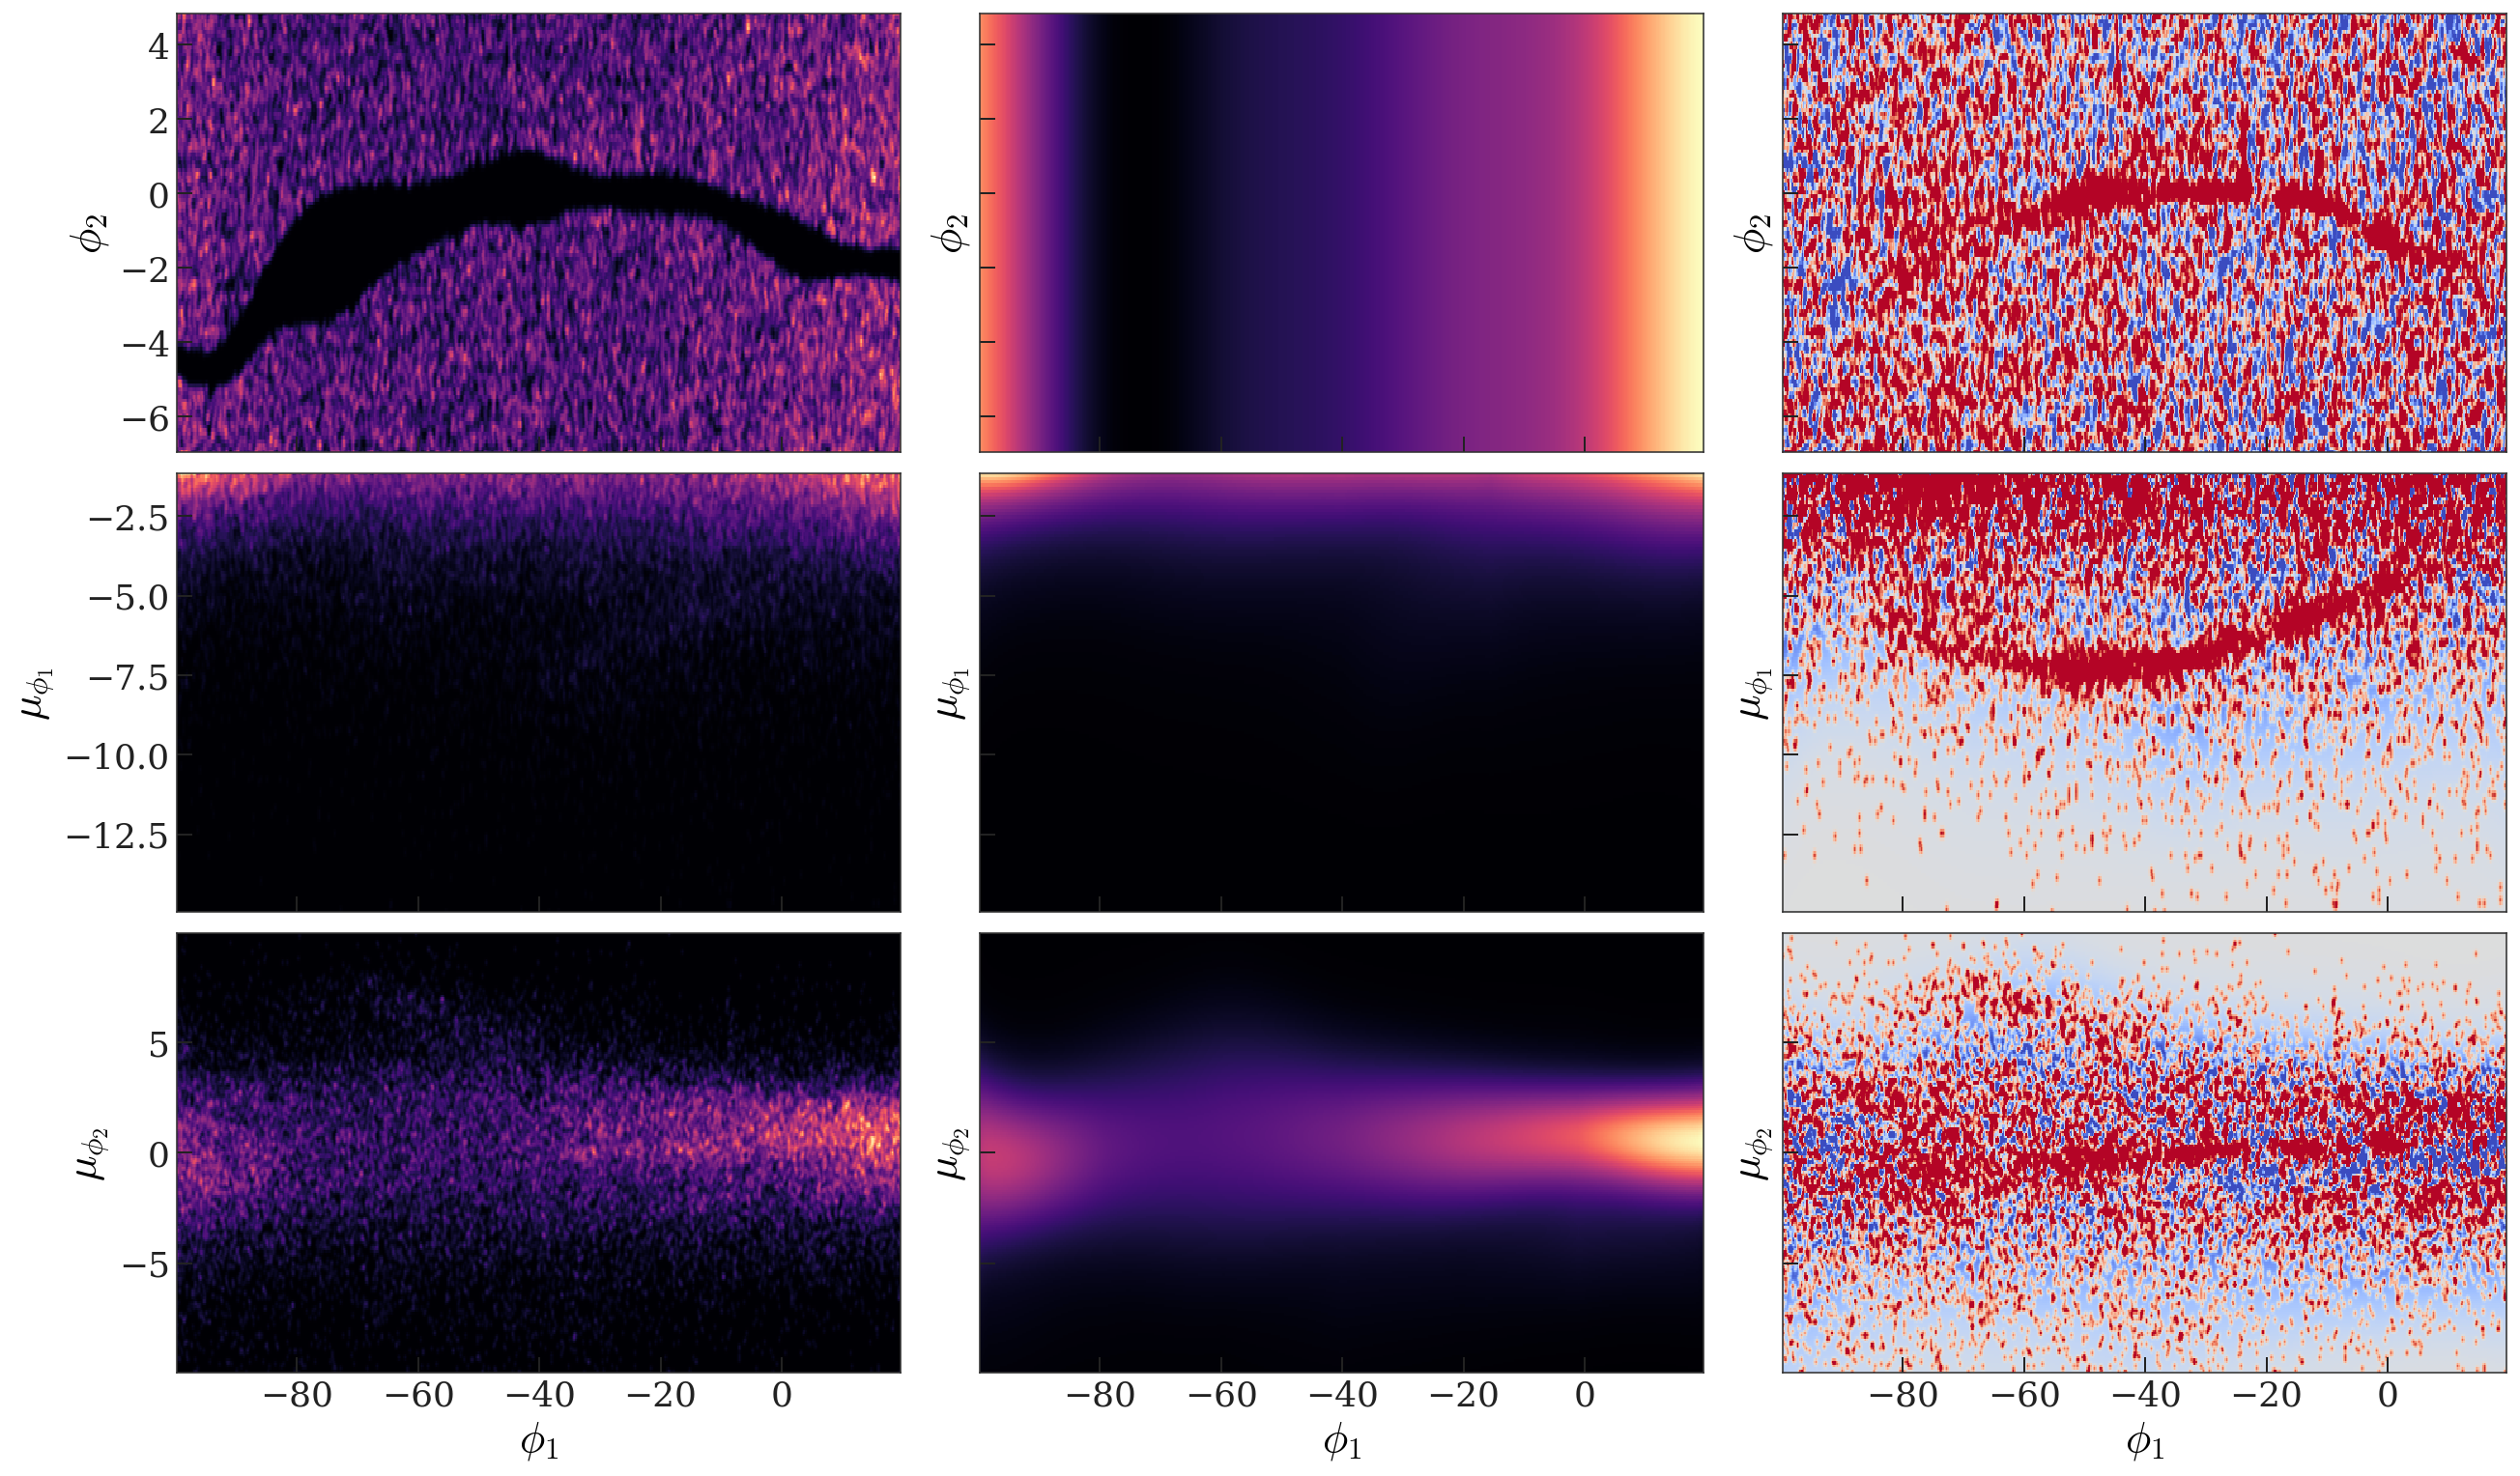

In [18]:
fig, axes = plt.subplots(
    len(background_opt.coord_names), 3, figsize=(18, 3.5 * len(background_opt.coord_names)), 
    sharex=True, sharey='row', constrained_layout=True
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data, 
    grids=GD1BackgroundModel.default_grids, 
    axes=axes[:, 0],
    coord_names=GD1BackgroundModel.coord_names
)
background_opt.plot_model_projections(axes=axes[:, 1]);
background_opt.plot_residual_projections(data=run_data, axes=axes[:, 2])
    
for ax in axes[-1]:
    ax.set_xlabel(r'$\phi_1$')

# Stream Model initialization

In [19]:
stream_mask = run_mask & masks['sky_track'] & masks['pm_rough']
stream_g = g[stream_mask]
stream_data = {k: v[stream_mask] for k, v in all_data.items()}

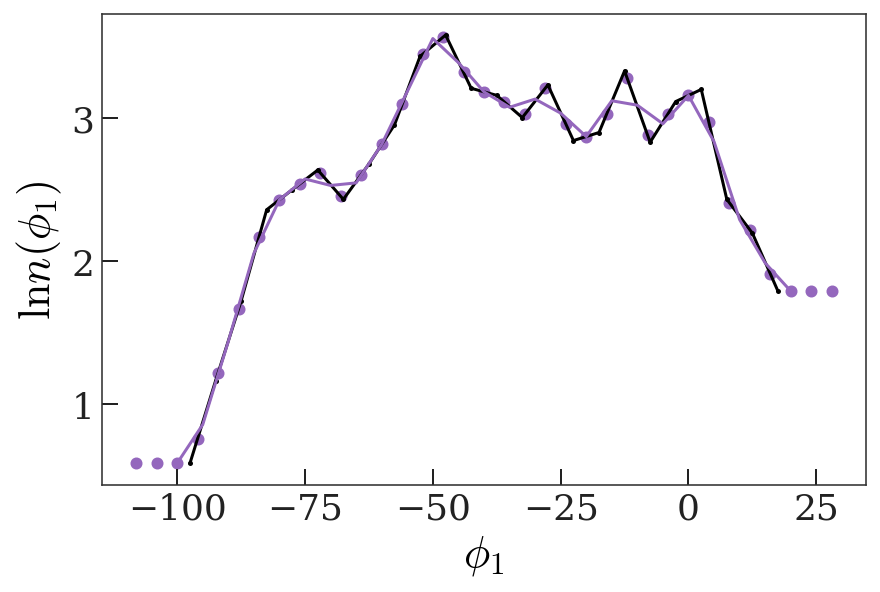

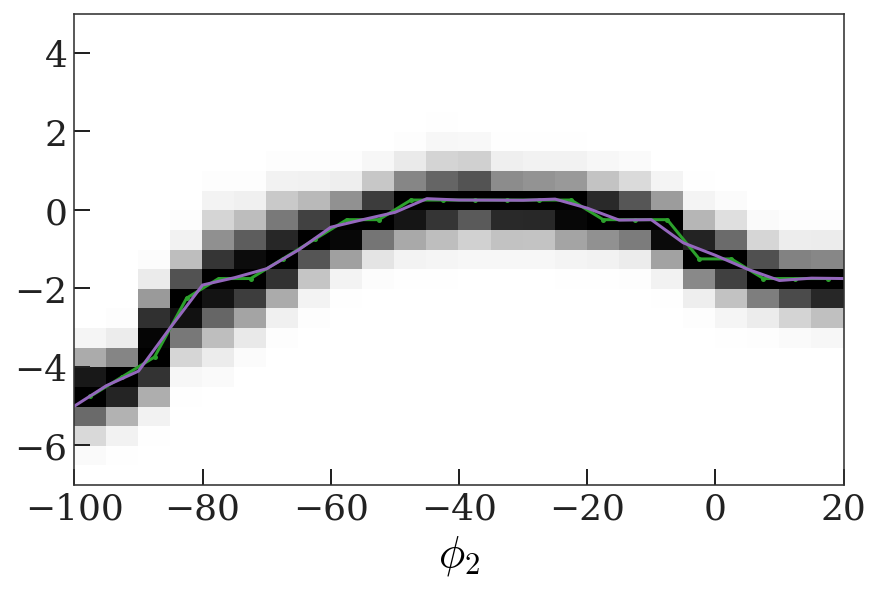

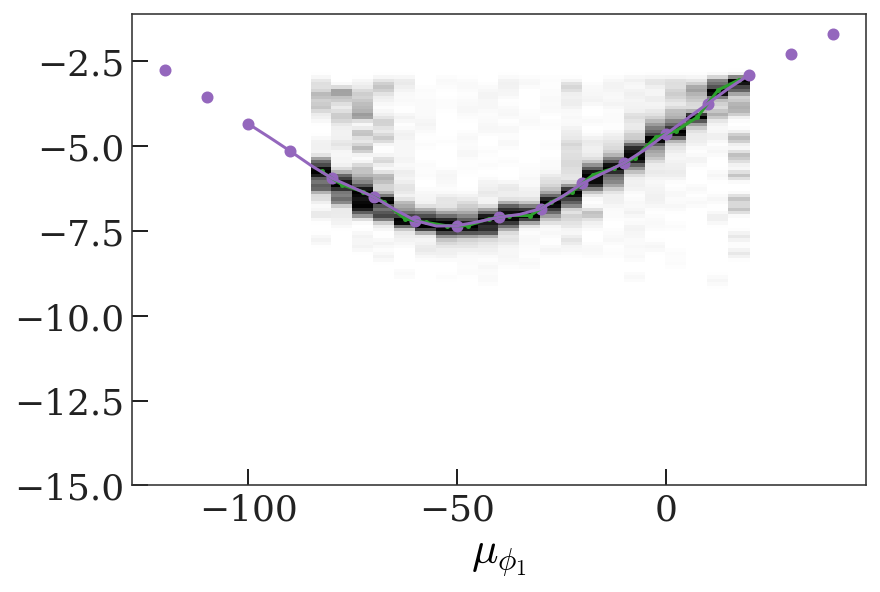

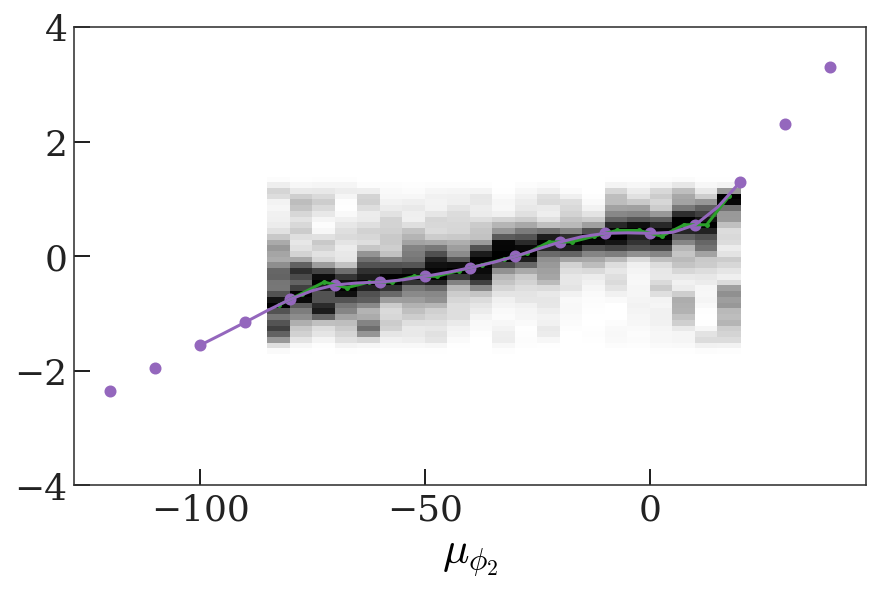

In [20]:
stream_initter = StreamInitializer(stream_data, plot=True)
stream_init_p = stream_initter.init(phi1_bins=np.arange(-85, 20+1e-3, 5))
stream_init_p = GD1StreamModel.clip_params(stream_init_p)

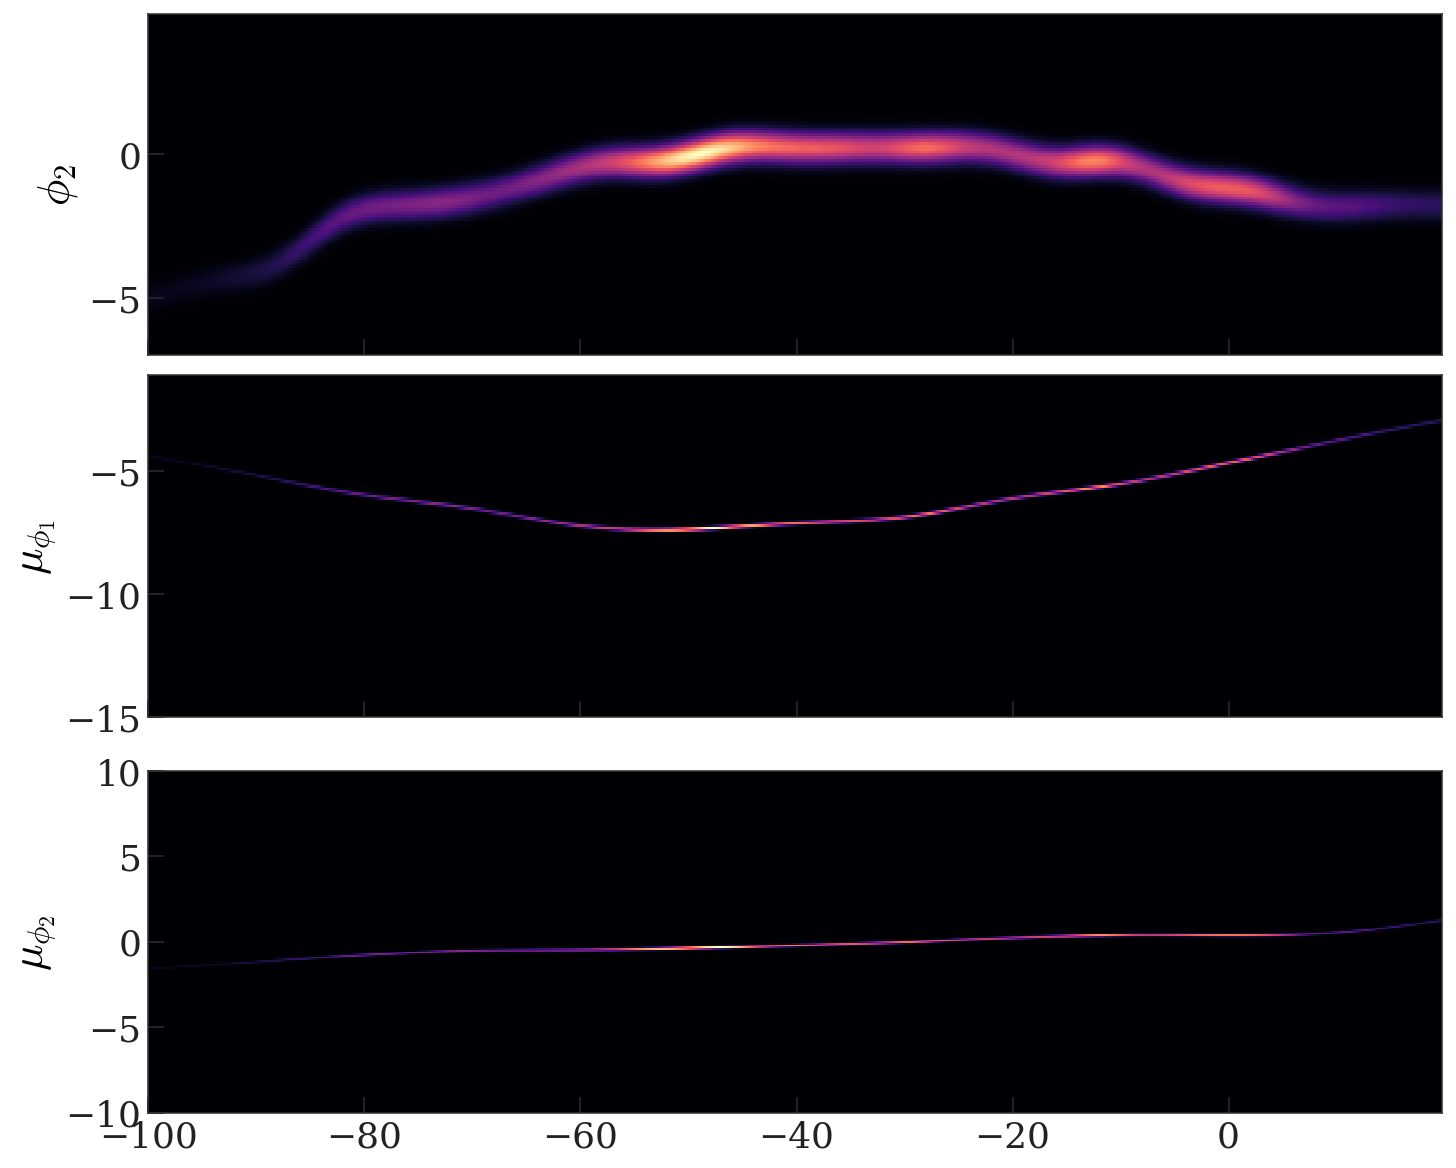

In [21]:
stream_init = GD1StreamModel(stream_init_p)
_ = stream_init.plot_model_projections()

In [22]:
stream_init.ln_likelihood(stream_data)

DeviceArray(-635897.50843681, dtype=float64)

Text(0, 0.5, '$\\phi_2$')

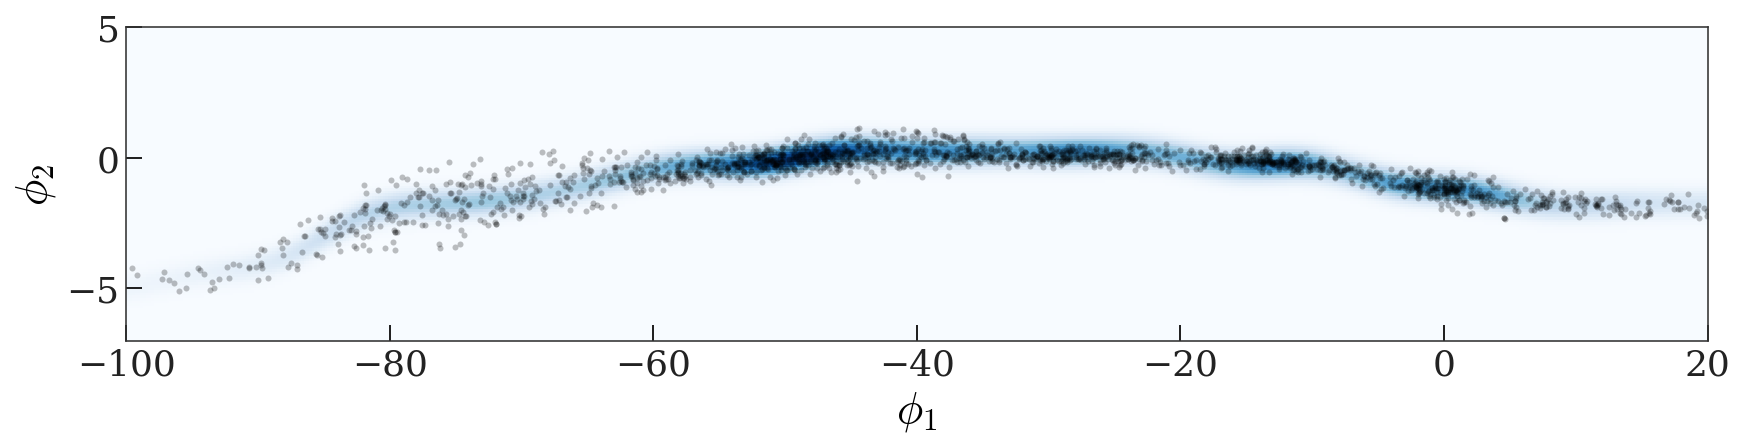

In [23]:
_grids, ln_dens = GD1StreamModel(stream_init_p).evaluate_on_grids()

fig, ax = plt.subplots(figsize=(12, 3), constrained_layout=True)

ax.plot(
    stream_data['phi1'],
    stream_data['phi2'],
    marker="o",
    markeredgewidth=0,
    markersize=3.0,
    ls="none",
    alpha=0.25,
)
ax.pcolormesh(
    _grids['phi2'][0],
    _grids['phi2'][1],
    np.exp(ln_dens['phi2']),
    cmap="Blues",
    shading='auto'
)
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

# Spur Model

In [24]:
# spur_init_p = {}
# spur_box = (
#     (c_gd1.phi1 > -60 * u.deg) &
#     (c_gd1.phi1 < 0 * u.deg) &
#     (c_gd1.phi2 > -4 * u.deg) &
#     (c_gd1.phi2 < 4 * u.deg)
# )
# spur_init_mask = masks['cmd_ms'] & masks['pm_rough'] & spur_box & (g.parallax < 0.5*u.mas)

In [25]:
# spur_sky_nodes_tmp = np.array([
#     [-110, 0],
#     [-80, 0],
#     [-50, 0],
#     [-45, 0],
#     [-40, 0.5],
#     [-35, 1.2],
#     [-30, 1.3],
#     [-25, 1.3],
#     [-20, 1.3],
#     [0, 1.3],
#     [20, 0.]
# ])

# fig, ax = plt.subplots(figsize=(8, 3), constrained_layout=True)

# ax.plot(
#     g.gd1_phi1[spur_init_mask],
#     g.gd1_phi2[spur_init_mask],
#     marker="o",
#     markeredgewidth=0,
#     markersize=5,
#     ls="none",
#     alpha=0.25,
# )

# # ax.plot(spur_sky_nodes_tmp[:, 0], spur_sky_nodes_tmp[:, 1], color='tab:purple', alpha=0.5)

# # ax.set_xlim()
# ax.set_ylim(-4, 4)

# ax.set_xlabel(r"$\phi_1$")
# ax.set_ylabel(r"$\phi_2$")

# spur_init_p['mean_phi2'] = sci.InterpolatedUnivariateSpline(
#     spur_sky_nodes_tmp[:, 0], 
#     spur_sky_nodes_tmp[:, 1],
#     k=1
# )(SpurModel.knots['phi2'])
# spur_init_p['ln_std_phi2'] = np.full_like(spur_init_p['mean_phi2'], -0.75)
# ax.plot(
#     spur_sky_nodes_tmp[:, 0], 
#     spur_sky_nodes_tmp[:, 1],
#     color='tab:red', alpha=0.5
# )
# ax.plot(
#     SpurModel.knots['phi2'],
#     spur_init_p['mean_phi2'], 
#     color='tab:green', 
#     zorder=100,
#     marker='o', ms=4
# )

# tmp = sci.InterpolatedUnivariateSpline(
#     SpurModel.knots['phi2'],
#     spur_init_p['mean_phi2'],
#     k=1
# )
# ax.plot(plot_grid_phi1, tmp(plot_grid_phi1), color='tab:purple', alpha=0.5)
# # ax.plot(SpurModel.phi2_knots, run_res_pars['spur']['mean_phi2'])

In [26]:
# spur_init_p['ln_n0'] = stream_ln_n0_interp_tmp(SpurModel.knots['ln_n0']) - 1.
# spur_init_p['ln_n0'] = np.clip(
#     spur_init_p['ln_n0'] 
#     + jax.nn.log_sigmoid((SpurModel.knots['ln_n0'] - -50) / 1.) 
#     + jax.nn.log_sigmoid((-SpurModel.knots['ln_n0'] - 20) / 1.),
#     a_min=-8,
#     a_max=None
# )

# plt.plot(SpurModel.knots['ln_n0'], spur_init_p['ln_n0'])

# tmp = SpurModel.setup_splines(spur_init_p)['ln_n0']
# _grid = np.linspace(-100, 20, 1024)
# plt.plot(_grid, tmp(_grid))

# Joint model:

In [27]:
mix_init_pars = {}
mix_init_pars[GD1StreamModel.name] = stream_init_p
mix_init_pars[GD1BackgroundModel.name] = bkg_opt_pars

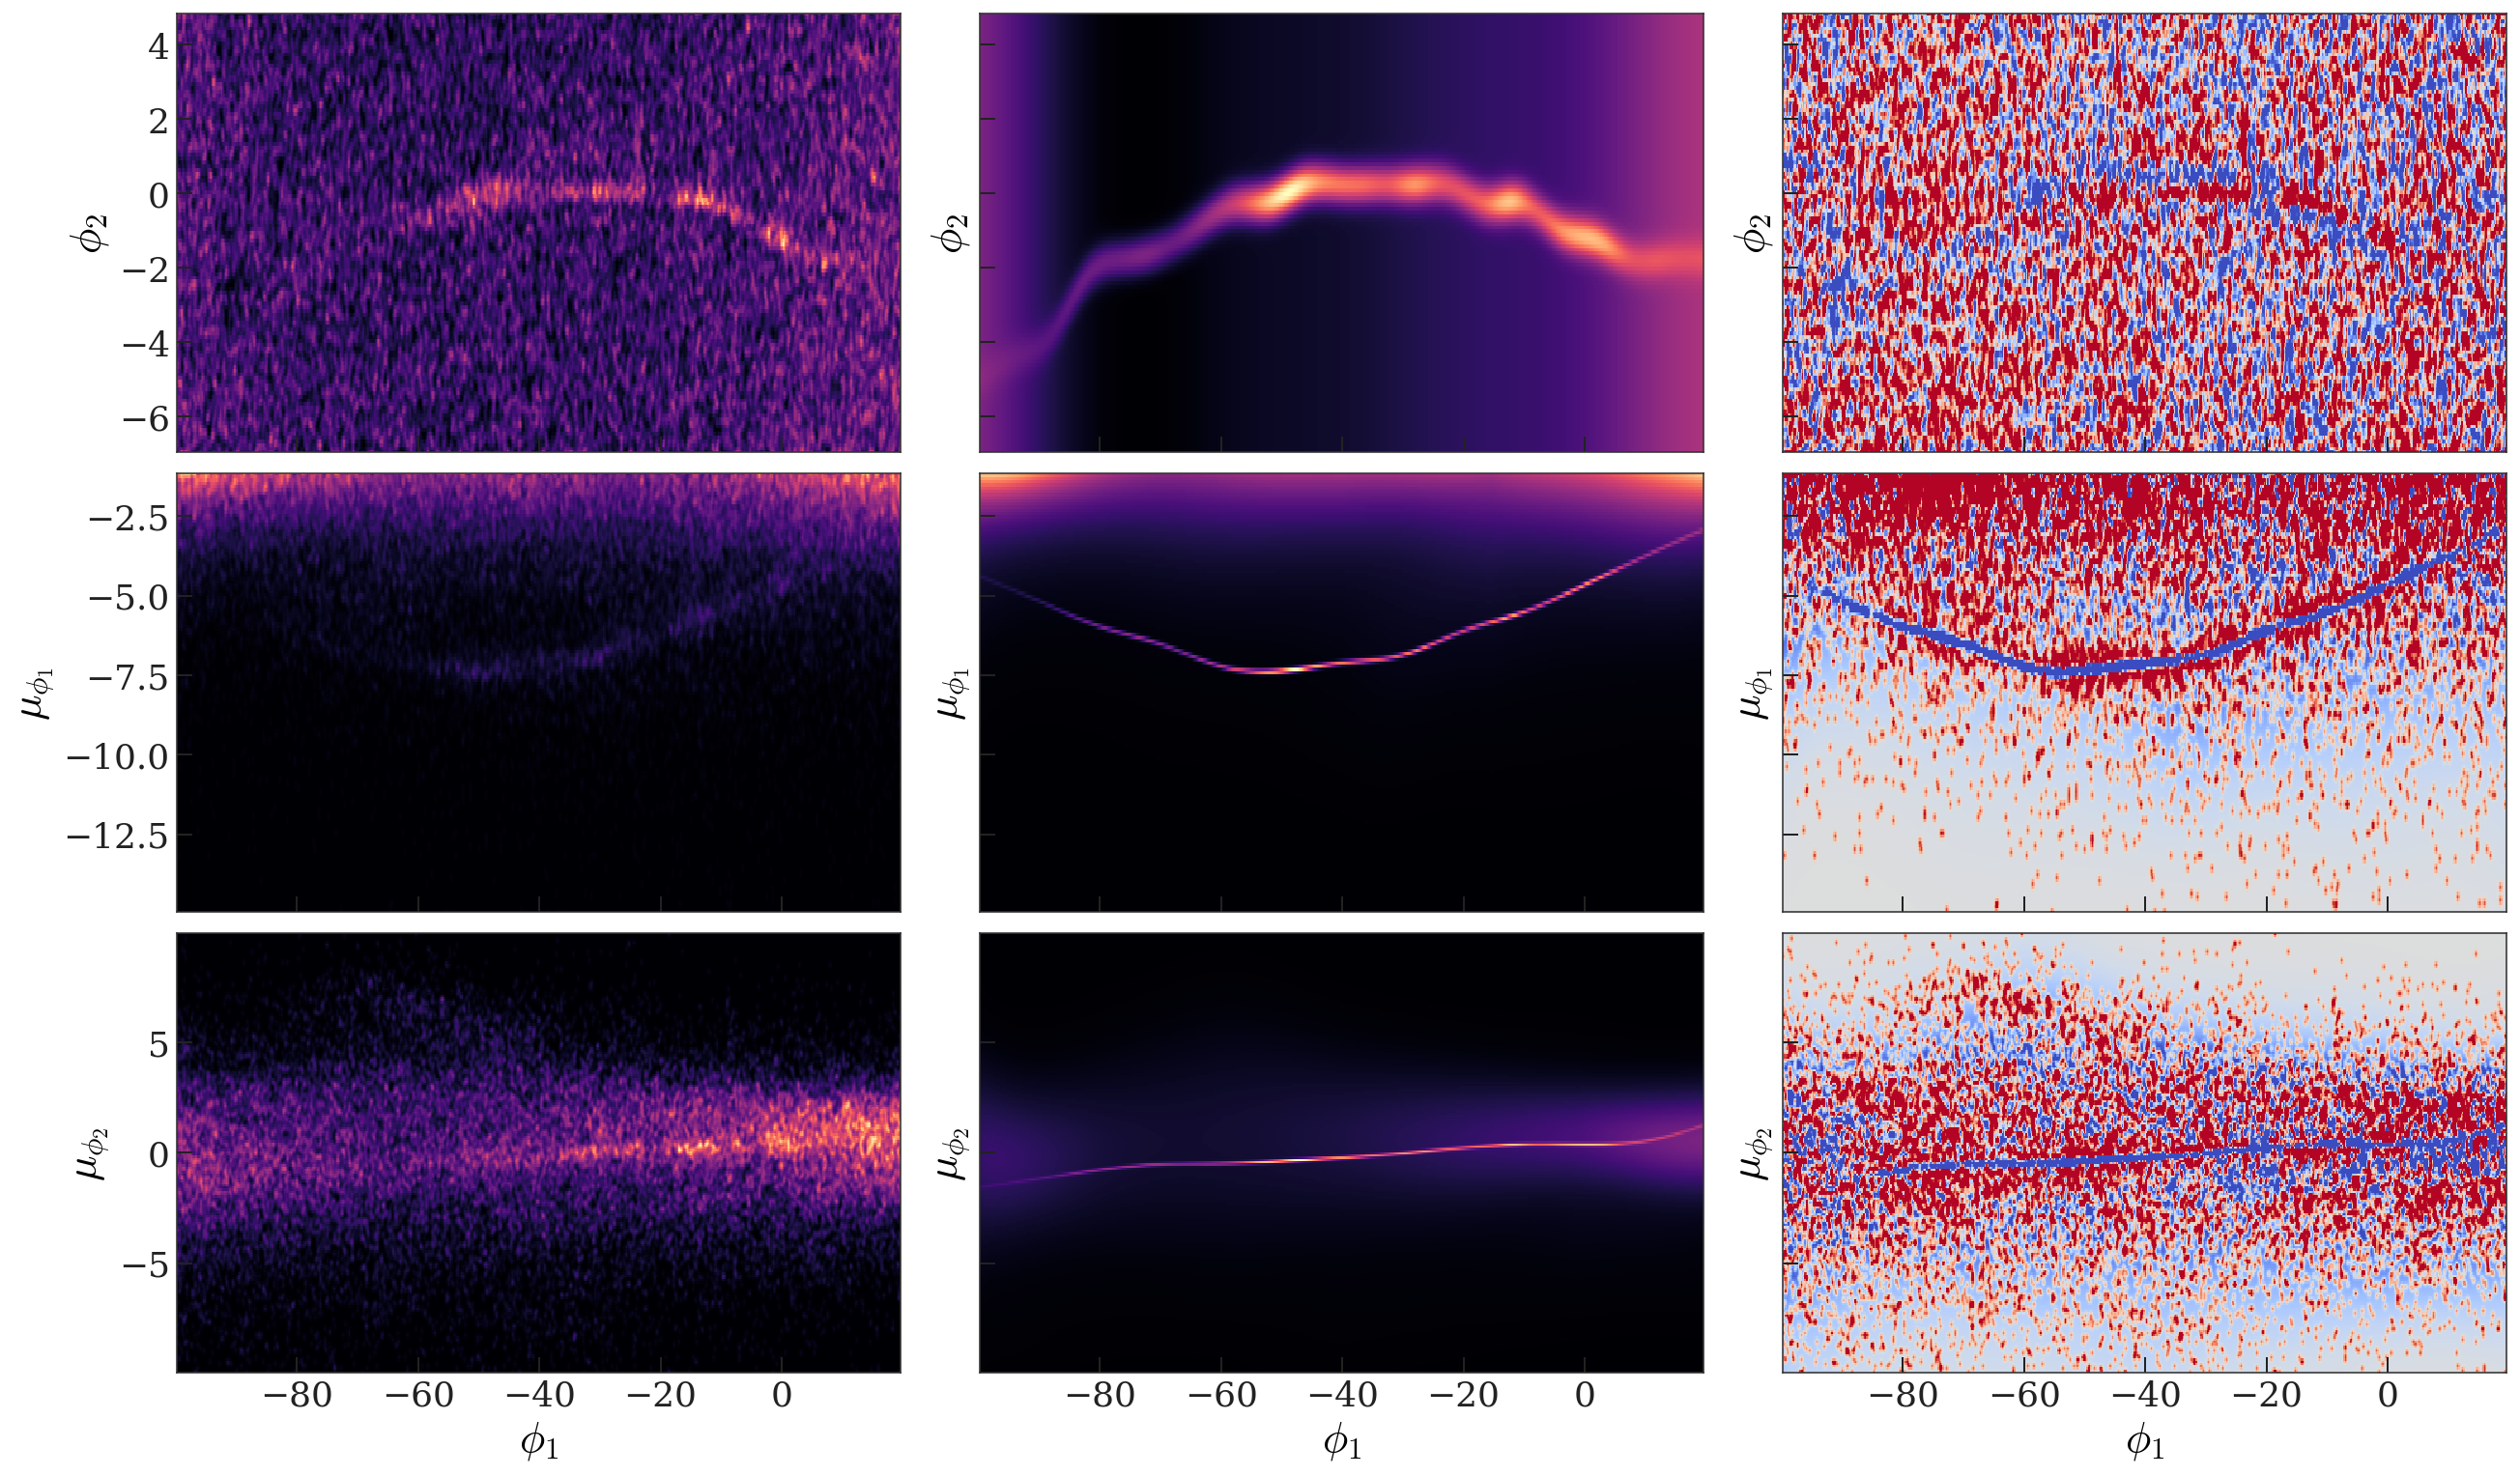

In [28]:
background_init = GD1BackgroundModel(mix_init_pars['background'])
stream_init = GD1StreamModel(mix_init_pars['stream'])
full_model_init = SplineDensityMixtureModel([background_init, stream_init])

fig, axes = plt.subplots(
    len(full_model_init.coord_names), 
    3, 
    figsize=(18, 3.5 * len(full_model_init.coord_names)), 
    sharex=True, sharey='row', constrained_layout=True
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data, grids=background_init.default_grids, 
    axes=axes[:, 0], coord_names=background_init.coord_names
)
full_model_init.plot_model_projections(axes=axes[:, 1]);
full_model_init.plot_residual_projections(data=run_data, axes=axes[:, 2])
    
for ax in axes[-1]:
    ax.set_xlabel(r'$\phi_1$')

## Run optimizer

TODO: run sampler
```
mcmc_kw = dict(
    num_warmup=100,
    num_samples=100,
    num_chains=4,
    chain_method="sequential",
)

mcmc = MCMC(NUTS(SplineDensityMixtureModel.setup_numpyro), **mcmc_kw)
mcmc.run(
    jax.random.PRNGKey(0), 
    Components=Components,
    data=gd1_data,
    init_params=init_pars_chains
)
```

In [29]:
Components = [GD1BackgroundModel, GD1StreamModel]

In [30]:
optimizer = jaxopt.ScipyBoundedMinimize(
    'l-bfgs-b',
    fun=lambda p, data: SplineDensityMixtureModel.objective(p, data=data, Components=Components),
    options=dict(maxls=10000),
    maxiter=100_000, 
)
opt_res = optimizer.run(
    init_params=mix_init_pars, 
    data=run_data,
    # Components=Components,
    bounds=SplineDensityMixtureModel._get_jaxopt_bounds(Components)
)
mix_opt_pars = opt_res.params
opt_res.state

ScipyMinimizeInfo(fun_val=DeviceArray(1.64661574, dtype=float64, weak_type=True), success=True, status=0, iter_num=1400)

In [31]:
full_model_opt = SplineDensityMixtureModel([
    GD1BackgroundModel(mix_opt_pars['background']), 
    GD1StreamModel(mix_opt_pars['stream'])
])

In [32]:
# Components = [GD1BackgroundModel, GD1StreamModel]
# # Components = [GD1BackgroundModel]
# mix_opt_pars, mix_info = SplineDensityMixtureModel.optimize(
#     data=run_data, 
#     init_params=init_pars, 
#     Components=Components,
#     jaxopt_kwargs=dict(maxiter=2048)
# )
# mix_info

(<Figure size 864x864 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'background'}, ylabel='ln_n0'>,
         <AxesSubplot:title={'center':'stream'}, ylabel='ln_n0'>],
        [<AxesSubplot:ylabel='phi2'>, <AxesSubplot:ylabel='phi2'>],
        [<AxesSubplot:ylabel='pm1'>, <AxesSubplot:ylabel='pm1'>],
        [<AxesSubplot:ylabel='pm2'>, <AxesSubplot:ylabel='pm2'>]],
       dtype=object))

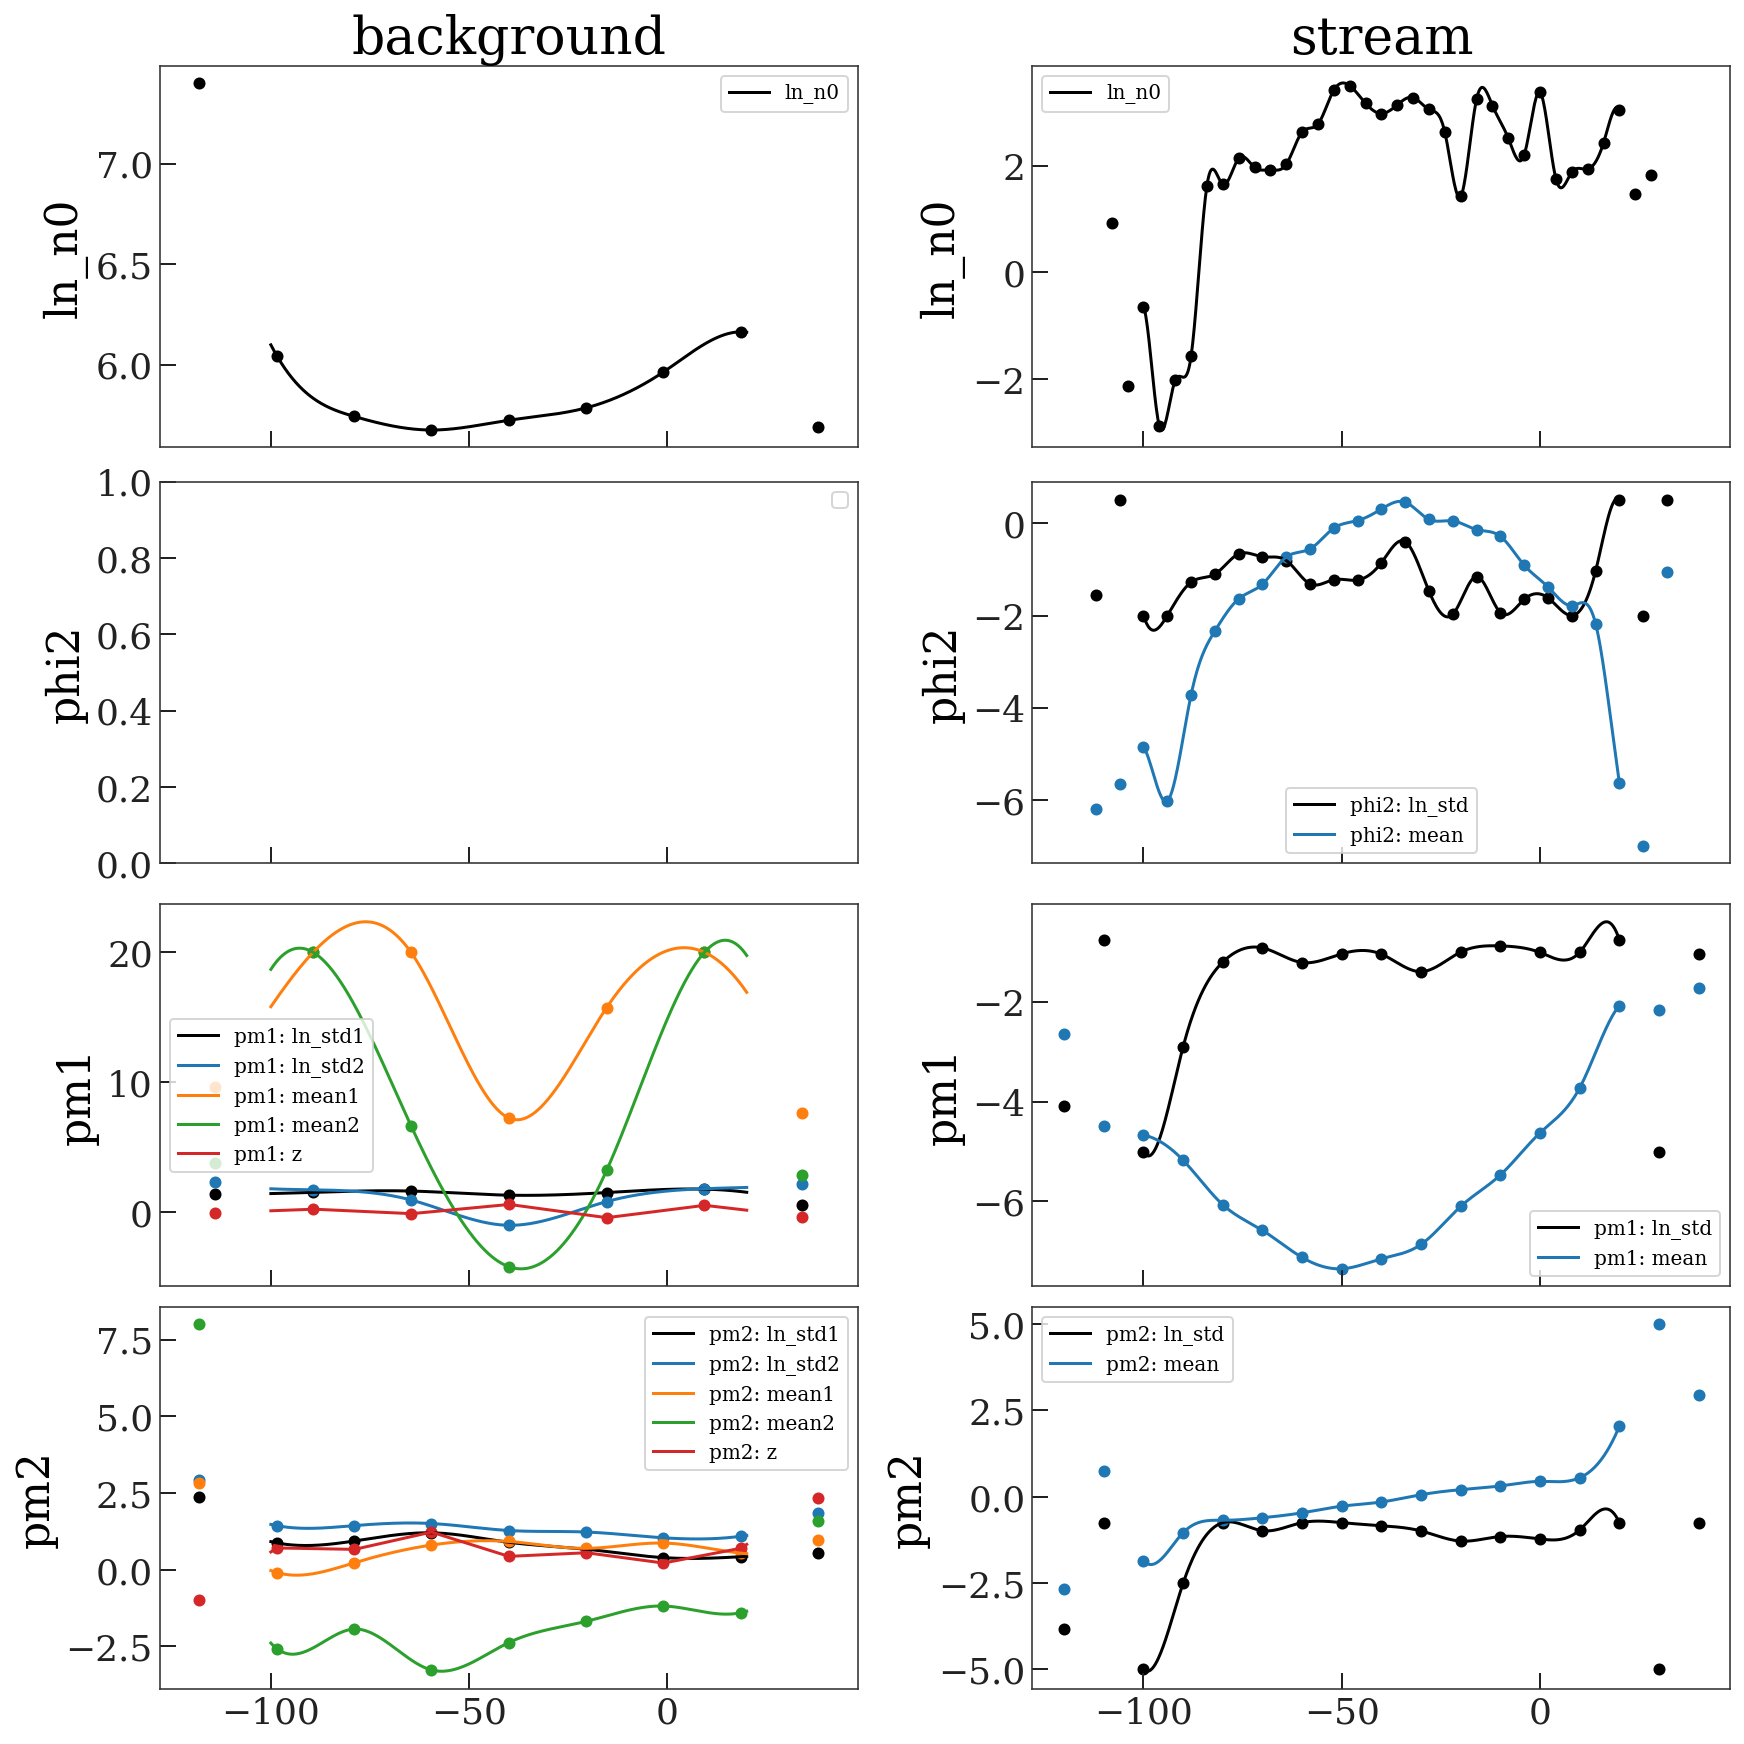

In [33]:
full_model_opt.plot_knots()

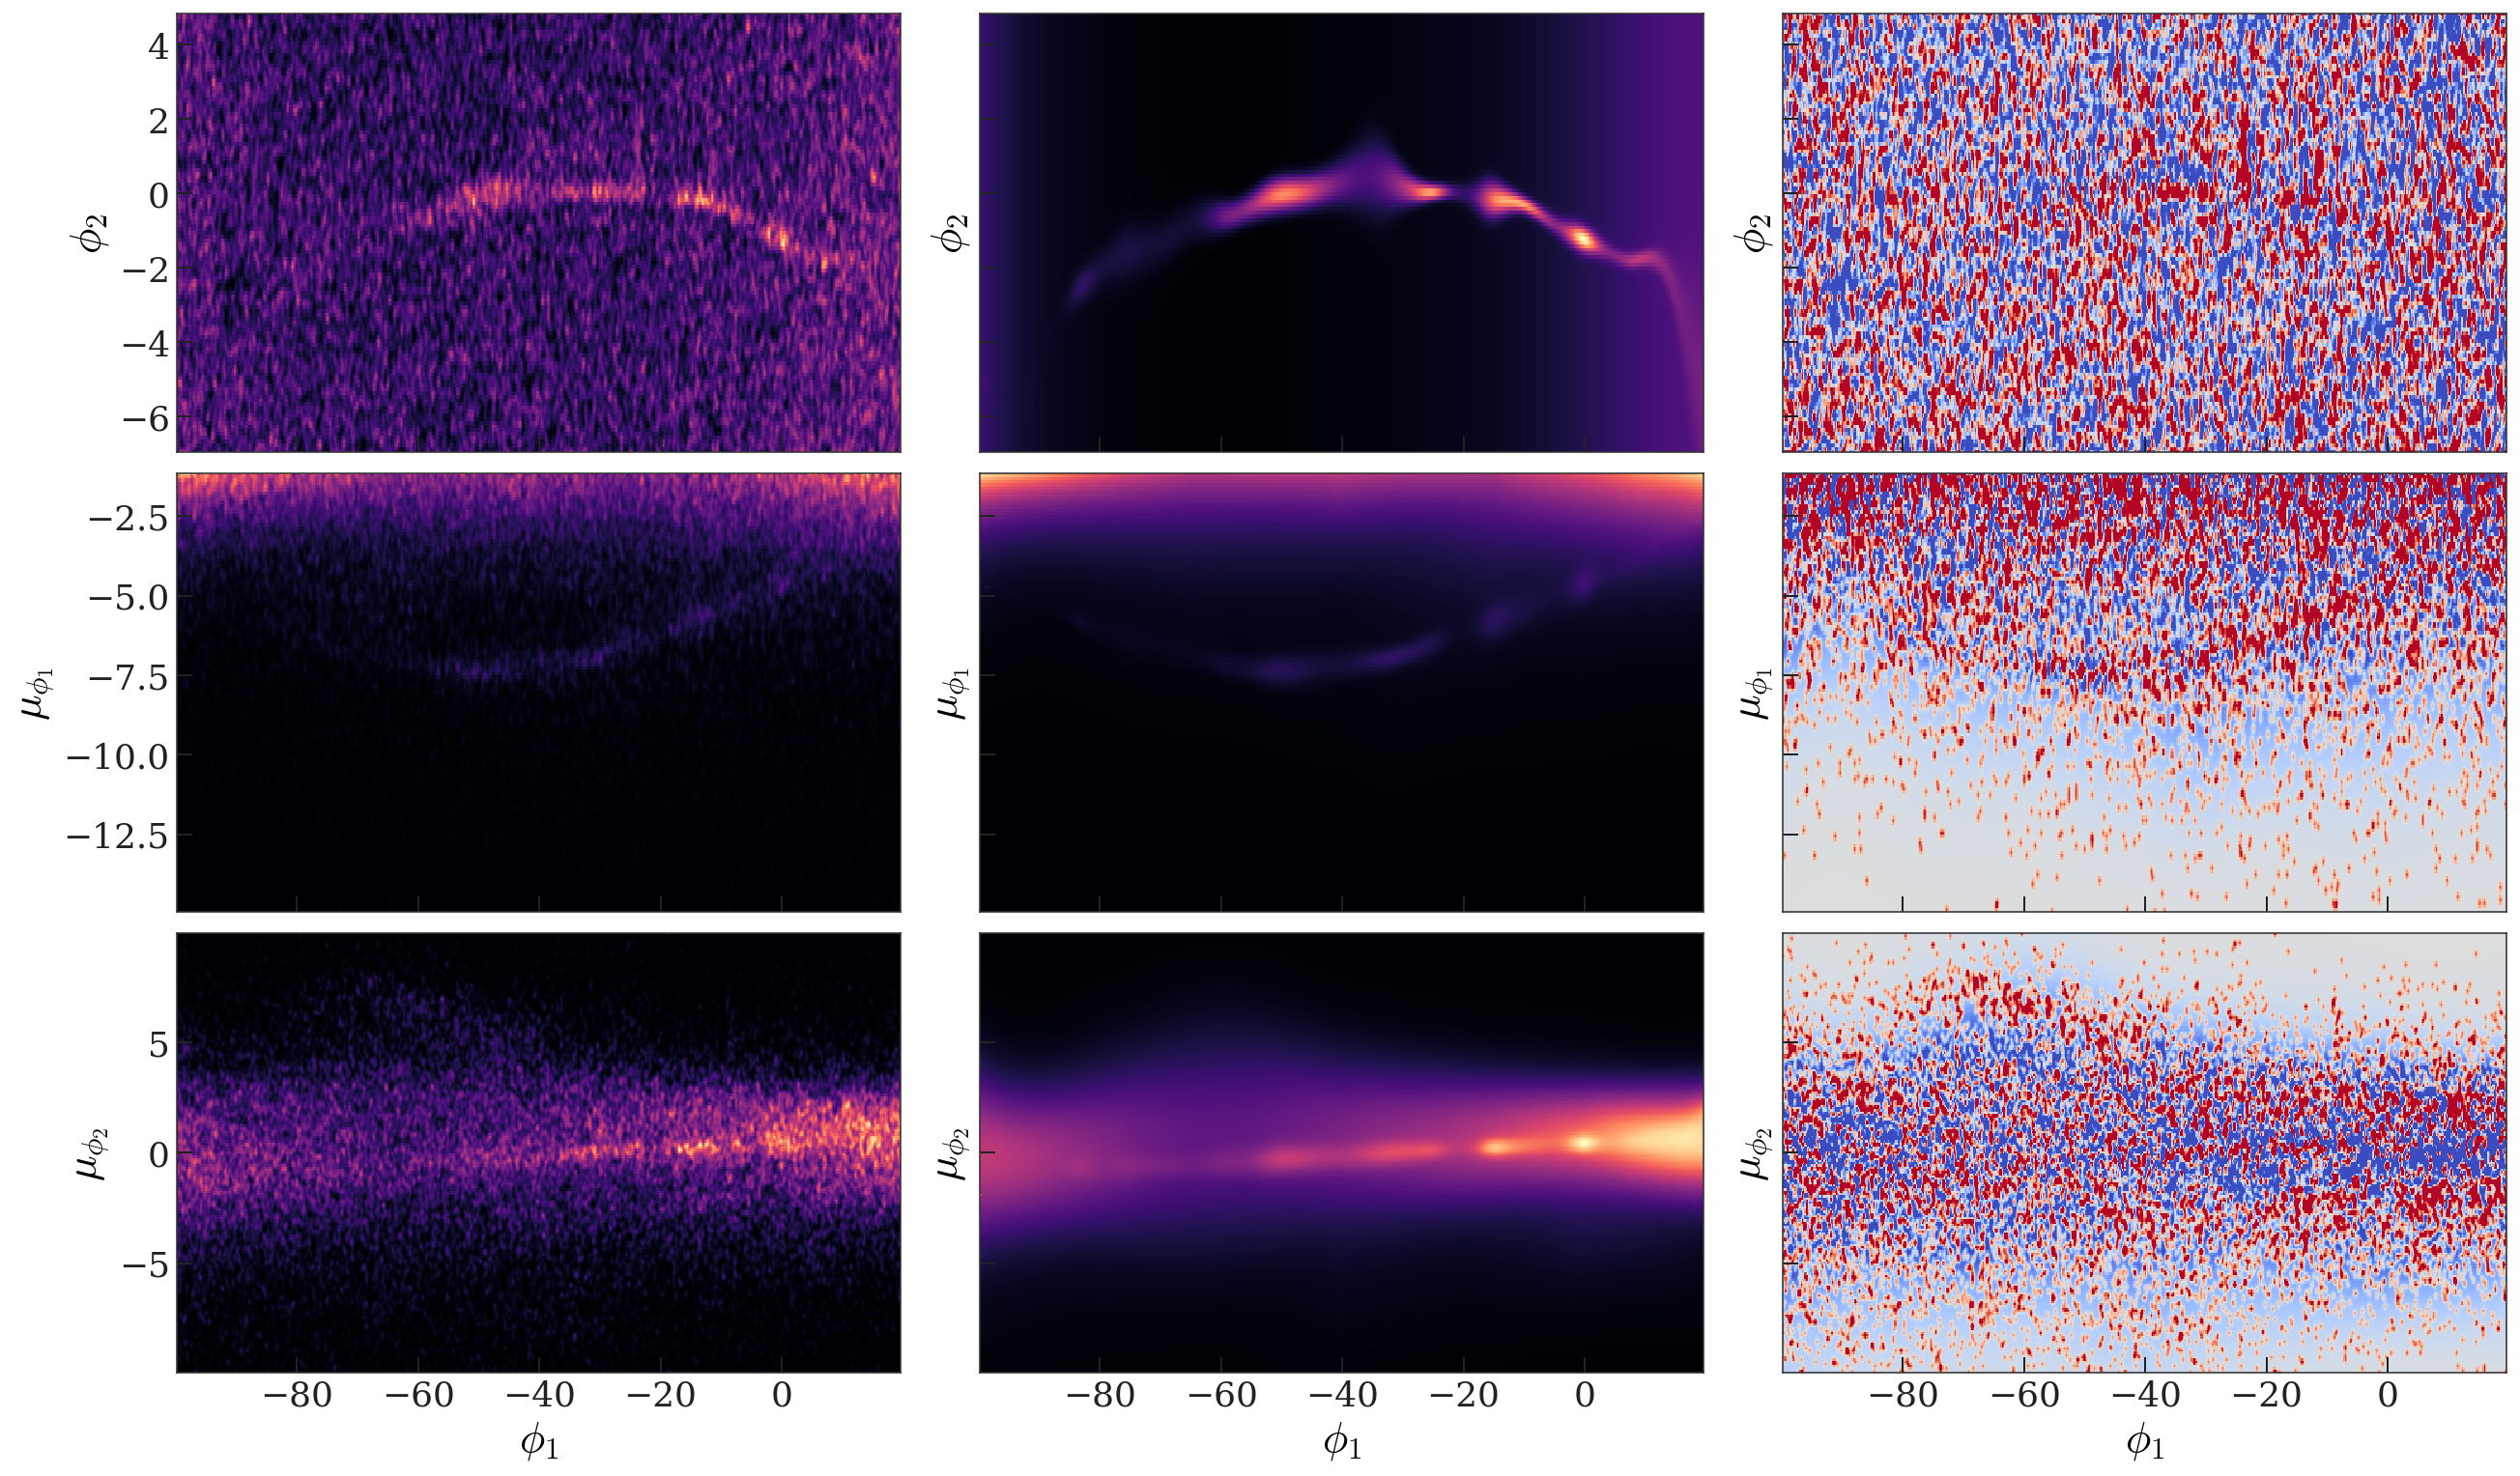

In [34]:
fig, axes = plt.subplots(
    len(full_model_opt.coord_names), 
    3, 
    figsize=(18, 3.5 * len(full_model_opt.coord_names)), 
    sharex=True, sharey='row', constrained_layout=True
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data, axes=axes[:, 0], 
    grids=GD1BackgroundModel.default_grids,
    coord_names=GD1BackgroundModel.coord_names
)
full_model_opt.plot_model_projections(axes=axes[:, 1]);
full_model_opt.plot_residual_projections(data=run_data, axes=axes[:, 2])
    
for ax in axes[-1]:
    ax.set_xlabel(r'$\phi_1$')

In [35]:
from numpyro import infer

In [36]:
nchains = 1

rng = np.random.default_rng(seed=42)

leaves, tree_def = jax.tree_util.tree_flatten(mix_opt_pars)
chain_leaves = []
for leaf in leaves:
    arr = jnp.reshape(leaf, (1,) + leaf.shape)
    arr = arr + rng.normal(0, 1e-3, size=(nchains,) + leaf.shape)
    chain_leaves.append(arr)
chain_init_p = jax.tree_util.tree_unflatten(tree_def, chain_leaves)

In [52]:
sum([len(x) for x in leaves])

242

In [37]:
Components = [GD1StreamModel, GD1BackgroundModel]

In [53]:
sampler = infer.MCMC(
    infer.NUTS(SplineDensityMixtureModel.setup_numpyro),
    num_warmup=1000,
    num_samples=100,
    num_chains=nchains,
    progress_bar=True,
)
sampler.run(
    jax.random.PRNGKey(0), 
    data=run_data, 
    Components=Components,
    init_params=chain_init_p
)

sample: 100%|██████████| 1100/1100 [9:45:50<00:00, 31.96s/it, 511 steps of size 7.03e-03. acc. prob=0.86]   


In [56]:
samples = sampler.get_samples()

In [57]:
samples['ln_n0_stream'].shape

(100, 35)

In [58]:
# import corner
# corner.corner(np.array(samples['ln_n0_stream'])[:, 15:20]);

In [65]:
i = -1
sample = {k: v[i] for k, v in samples.items()}
sample_pars = SplineDensityMixtureModel.unpack_params(sample, Components)
mix_sample = SplineDensityMixtureModel([
    GD1StreamModel(sample_pars['stream']), 
    GD1BackgroundModel(sample_pars['background'])
])

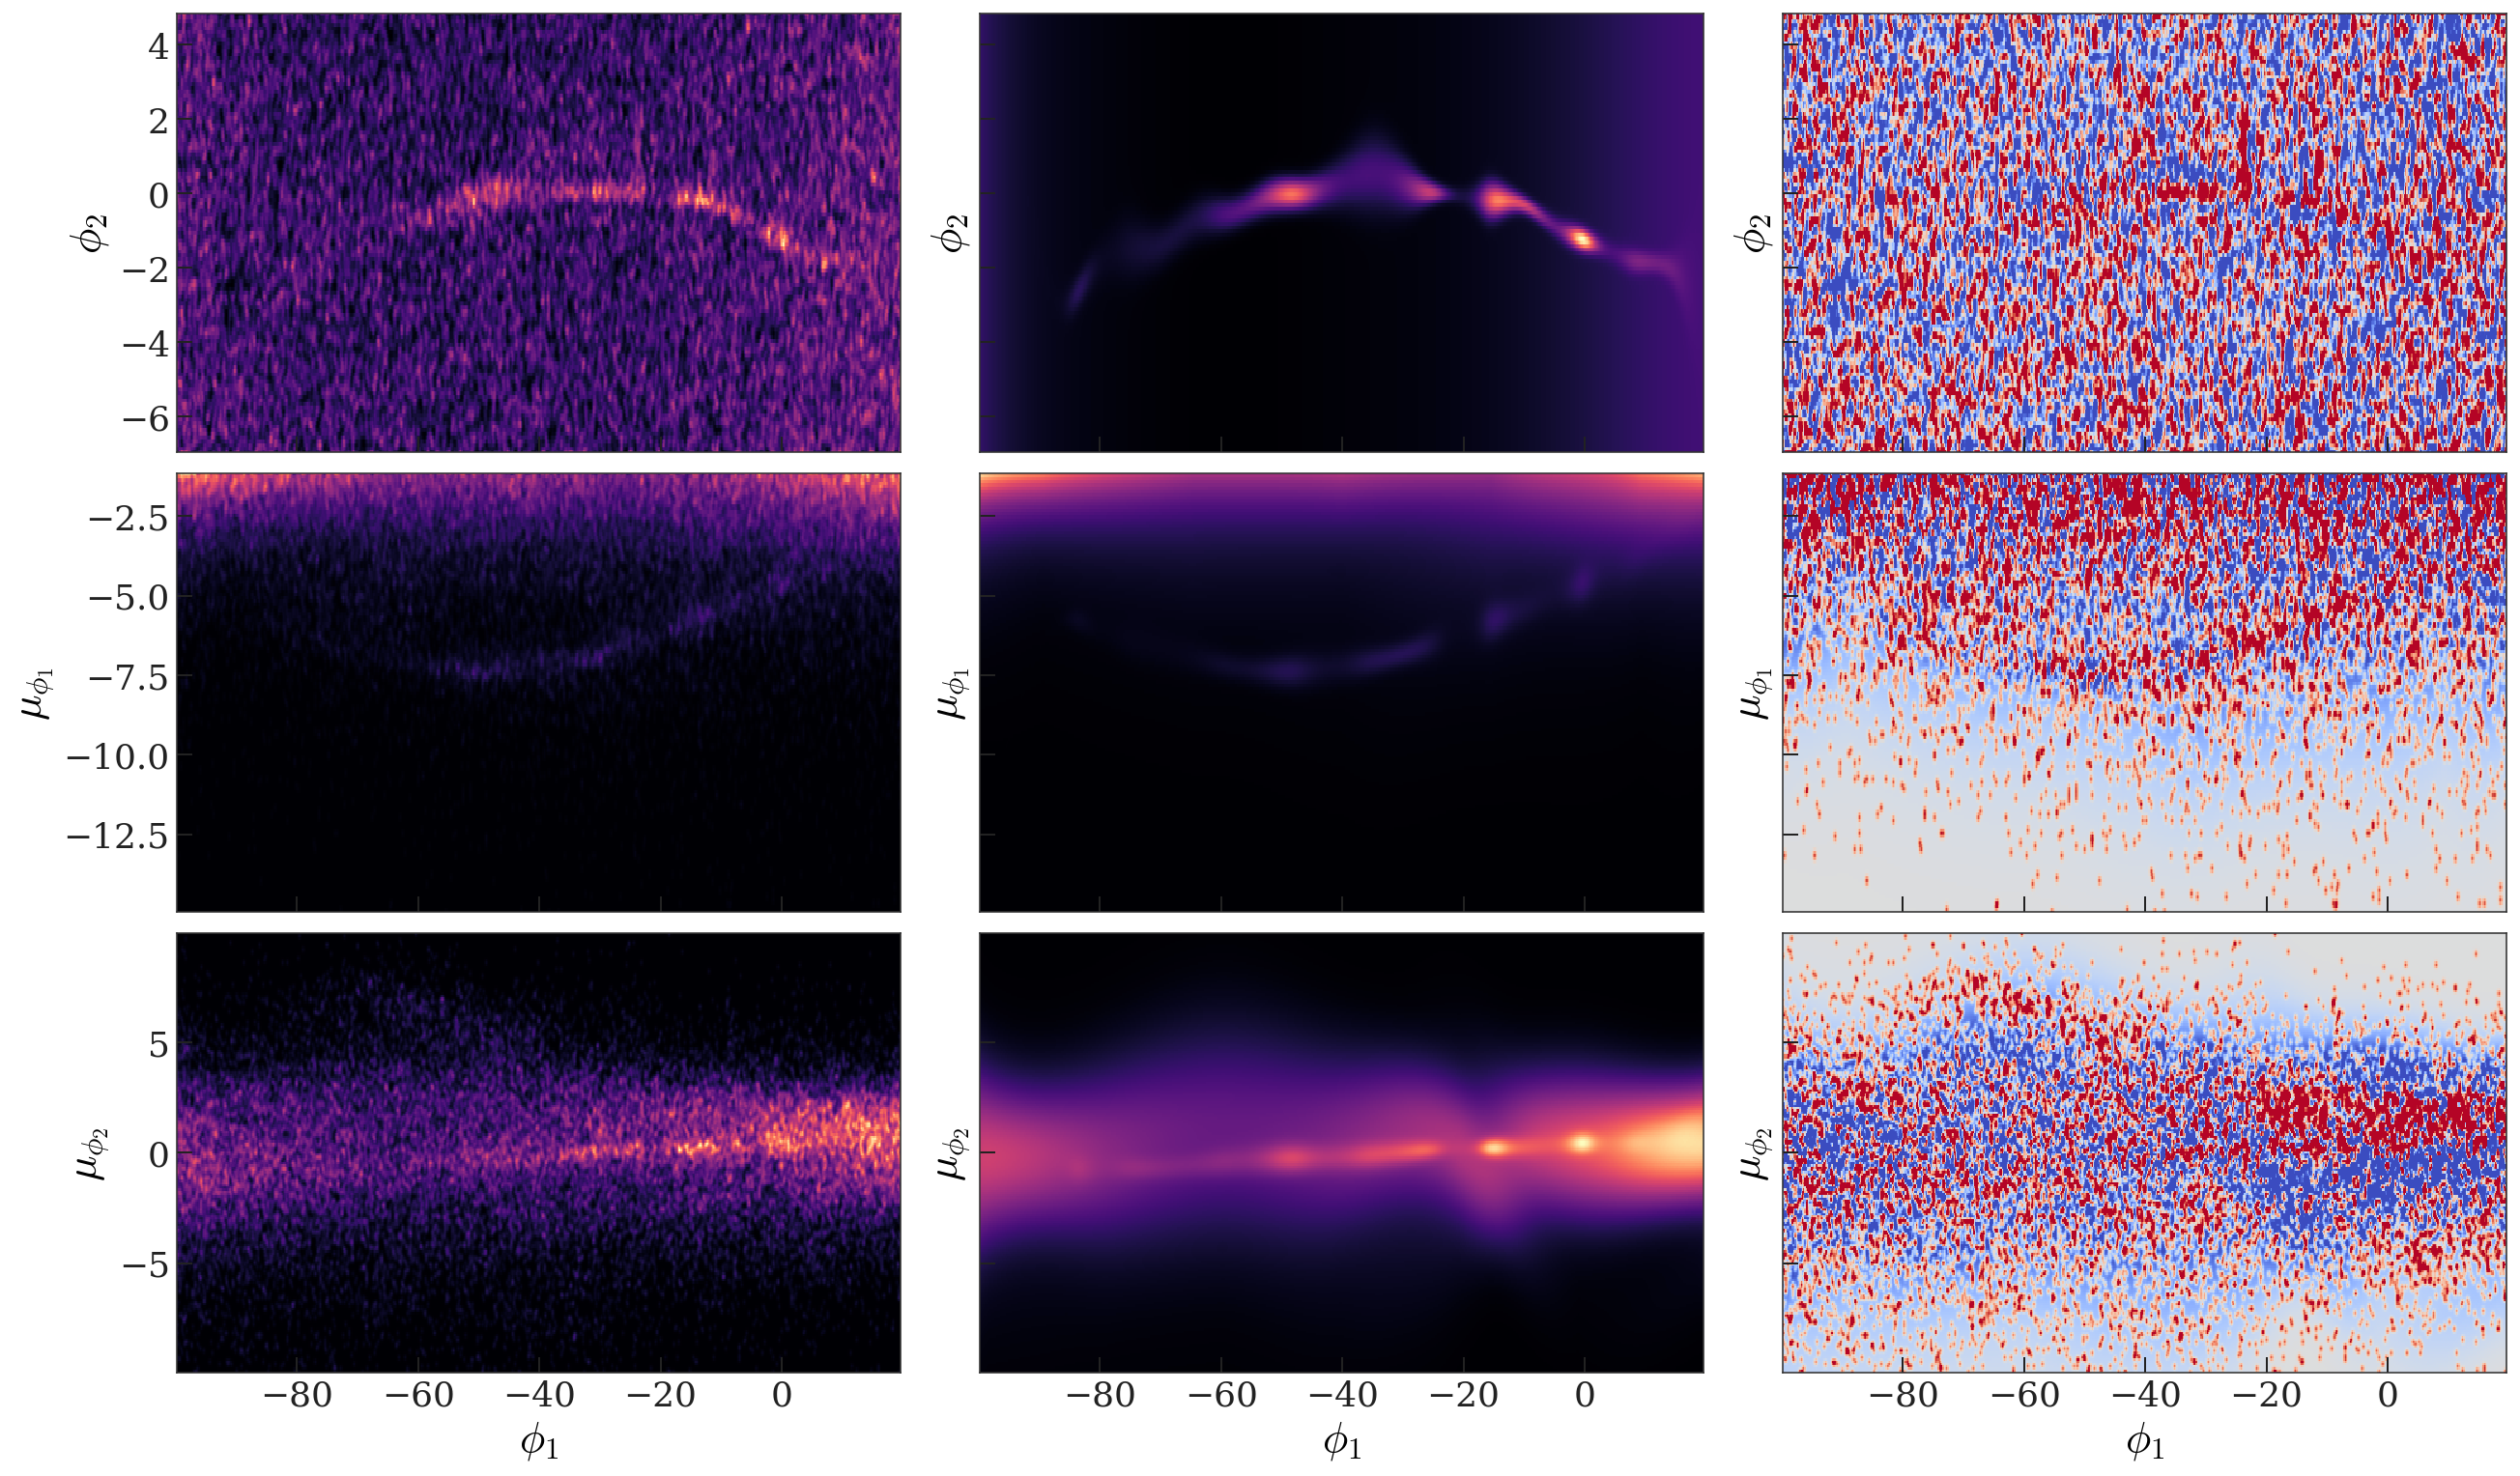

In [66]:
fig, axes = plt.subplots(
    len(mix_sample.coord_names), 
    3, 
    figsize=(18, 3.5 * len(mix_sample.coord_names)), 
    sharex=True, sharey='row', constrained_layout=True
)

axes = np.atleast_2d(axes)
plot_data_projections(data=run_data, grids=mix_sample.default_grids, axes=axes[:, 0]);
mix_sample.plot_model_projections(axes=axes[:, 1]);
mix_sample.plot_residual_projections(data=run_data, axes=axes[:, 2])
    
for ax in axes[-1]:
    ax.set_xlabel(r'$\phi_1$')

## TEST: sampling

In [50]:
rng = np.random.default_rng(seed=42)

n_chains = 2

init_pars_chains = {}
for C in Components:
    C_pars = init_pars[C.name]
    
    sub = {}
    tmp = C_pars[C.density_name]
    sub[C.density_name] = rng.normal(tmp, 1e-2, size=(n_chains, len(tmp)))
    
    for coord_name in C.coord_names:
        if coord_name not in sub:
            if coord_name not in C_pars or not C_pars[coord_name]:
                continue
            sub[coord_name] = {}
        
        for par_name, tmp in C_pars[coord_name].items():
            sub[coord_name][par_name] = rng.normal(tmp, 1e-2, size=(n_chains, len(tmp)))
    
    init_pars_chains[C.name] = sub

In [ ]:
mcmc_kw = dict(
    num_warmup=100,
    num_samples=100,
    num_chains=n_chains,
    chain_method="sequential",
)

mcmc = MCMC(NUTS(SplineDensityMixtureModel.setup_numpyro), **mcmc_kw)
mcmc.run(
    jax.random.PRNGKey(0), 
    Components=Components,
    data=run_data, 
    init_params=init_pars_chains
)

warmup:  21%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                      | 42/200 [16:34<2:18:34, 52.62s/it, 1023 steps of size 3.51e-03. acc. prob=0.72]

In [ ]:
mcmc.print_summary()

In [ ]:
samples = mcmc.get_samples()
samples_unpacked = SplineDensityMixtureModel.unpack_params(samples, Components)

In [ ]:
nsamples = 4
fig, axes = plt.subplots(
    nsamples, 1, figsize=(10, nsamples * 2.5), sharex=True, sharey=True, constrained_layout=True
)

rng = np.random.default_rng(32)
for j, i in enumerate(rng.choice(samples['ln_n0_background'].shape[0], size=nsamples)):
    sample_unpacked = SplineDensityMixtureModel.unpack_params(
        {k: v[i] for k, v in samples.items()}, 
        Components
    )
    sample_mixture = SplineDensityMixtureModel([C(sample_unpacked[C.name]) for C in Components])
    sample_mixture.plot_model_projections(axes=np.array([axes[j]]))

In [ ]:
sample_mixture.plot_knots()

## Plot results

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(22, 10), 
                         sharex=True, sharey='row', constrained_layout=True)

plot_data_projections(run_data, axes=axes[:, 0])
plot_model_projections(run_res_pars, axes=axes[:, 1], label=False, 
                       components=['background'], plot_stream_knots=False);
plot_model_projections(run_res_pars, axes=axes[:, 2], label=False, 
                       components=['stream', 'spur']);

## Post-processing

Compute stream probability membership:

In [ ]:
ll_bg = BackgroundModel.ln_likelihood(run_res_pars['background'], all_data)[1]

In [ ]:
ll_fg = np.logaddexp(
    StreamModel.ln_likelihood(run_res_pars['stream'], all_data)[1],
    SpurModel.ln_likelihood(run_res_pars['spur'], all_data)[1]
)

In [ ]:
post_prob = np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))
at.Table({'source_id': g.source_id, 'member_prob': post_prob}).write(
    cache_path / 'optimized-member-prob.fits',
    overwrite=True
)

plt.hist(post_prob[np.isfinite(post_prob)], bins=np.linspace(0, 1, 128));
plt.yscale('log')

Cache optimized parameters and model, do sampling in new notebook

In [ ]:
with open(cache_path / 'joint-model.pkl', 'wb') as f:
    pickle.dump((JointModel, run_res_pars), f)

# Visualize high probability members

In [ ]:
prob_mask = post_prob > 0.05
# prob_mask = (post_prob > 0.1) & (post_prob < 0.9)

fig, ax = plt.subplots(figsize=(12, 3), constrained_layout=True)

ax.plot(
    g.gd1_phi1[prob_mask],
    g.gd1_phi2[prob_mask],
    marker="o",
    markeredgewidth=0,
    markersize=3.0,
    ls="none",
    alpha=0.25,
)
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

In [ ]:
prob_mask = post_prob > 0.8

fig, axes = plt.subplots(2, 1, figsize=(12, 6), constrained_layout=True, sharex=True)

axes[0].plot(
    g.gd1_phi1[prob_mask],
    g.gd1_phi2[prob_mask],
    marker="o",
    markeredgewidth=0,
    markersize=3.0,
    ls="none",
    alpha=0.25,
)
axes[0].set_xlim(-100, 20)
axes[0].set_ylim(-7, 5)
axes[0].text(-98, 4.4, 'prob > 0.8 stream members', ha='left', va='top', fontsize=20)

# ---

n0_interp = sci.InterpolatedUnivariateSpline(
    StreamModel.ln_n0_knots,
    run_res_pars['stream']['ln_n0'],
    k=3
)
tmp_grid = np.linspace(-100, 20, 1024)
axes[1].plot(tmp_grid, np.exp(n0_interp(tmp_grid)), marker='', lw=2, label='main stream')

n0_interp = sci.InterpolatedUnivariateSpline(
    SpurModel.ln_n0_knots,
    run_res_pars['spur']['ln_n0'],
    k=3
)
tmp_grid = np.linspace(-100, 20, 1024)
axes[1].plot(tmp_grid, np.exp(n0_interp(tmp_grid)), marker='', lw=2, label='spur')
axes[1].legend(loc='upper left', fontsize=16)

axes[1].axhline(0, color='#aaaaaa', zorder=-1)

axes[1].set_xlabel(r"$\phi_1$")
axes[0].set_ylabel(r"$\phi_2$")
axes[1].set_ylabel(r"$n(\phi_1)$ [${\rm stars}\,{\rm deg}^{-1}$]")

In [ ]:
prob_mask = post_prob > 0.05

fig, ax = plt.subplots(figsize=(6.5, 6))

cs = ax.scatter(
    (g.g0 - g.i0)[prob_mask],
    (g.r0 - g.rough_distmod.value)[prob_mask],
    c=post_prob[prob_mask],
    s=8,
    alpha=0.5,
    linewidth=0.5,
    edgecolor='#aaaaaa',
    cmap='magma_r',
    vmin=0, vmax=1
)
cb = fig.colorbar(cs)
cb.set_label('membership prob.')

ax.set_xlim(-1.2, 2)
ax.set_ylim(7., -3)

ax.set_xlabel('$(g-i)_0$')
ax.set_ylabel(r'$r_0 - {\rm DM}$')

fig.tight_layout()

For HB selection & members, plot apparent mag vs. phi1

In [ ]:
strict_prob_mask = post_prob > 0.8

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    (g.g0 - g.i0)[strict_prob_mask],
    (g.r0 - g.rough_distmod.value)[strict_prob_mask],
    s=5,
    alpha=0.5
)

_nodes = np.array([
    [-1, 3.8],
    [-0.5, 0.5],
    [0, 0],
    [0.35, 0],
    [0.35, 0.4],
    [0, 1],
    [-0.5, 2],
    [-0.95, 4.1]
])
hb_path = mpl.path.Path(_nodes)
ax.plot(_nodes[:, 0], _nodes[:, 1], color='tab:purple')

hb_mask = hb_path.contains_points(
    np.stack((g.g0 - g.i0, g.r0 - g.rough_distmod.value)).T
)

ax.set_xlim(-1.2, 2)
ax.set_ylim(7., -3)

ax.set_xlabel('$(g-i)_0$')
ax.set_ylabel(r'$r_0 - {\rm DM}$')

fig.tight_layout()

In [ ]:
_mask = strict_prob_mask & hb_mask

fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True, constrained_layout=True)

axes[0].scatter(g.gd1_phi1[_mask], g.gd1_phi2[_mask])
axes[0].set_xlim(-100, 20)
axes[0].set_ylim(-7, 5)

axes[1].scatter(
    g.gd1_phi1[_mask], 
    g.r0[_mask], c=(g.g0 - g.i0)[_mask], 
    vmin=-1, vmax=0,
    linewidth=1,
    edgecolor='#cccccc'
)

In [ ]:
wut_mask = hb_mask & (post_prob < 0.8) & (post_prob > 0.05)
wut_mask.sum()